# Data Analysis of Images from Lab for measuring speed of light

In [1]:
# import librares 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import cv2


In [2]:
# declare constants and variables
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22']

# Measurements
freqs = [0, 66, 200, 284, 372, 491, 639, 783, 908] #rev/s
freqs_rad = [0 for i in range(len(freqs))] #rad/s
for i in range(len(freqs)):
    freqs_rad[i] = freqs[i] * 2 * np.pi
a = 4.94 #m
f = 4.71238 #m
b = 9.564 #m
c = 299792458 #m/s
sigma_w = 6.28 # rad/s
sigma_a = 0.001 # m
sigma_f = 0.001 # m
sigma_b = 0.002 # m
sigma_x = 0.0001 # m

In [3]:
# scan_img_intensity({string} path);
#   Scans an image horizontally, adding up all intensities in each column.
#   Returns an array of intensities mapped to the x within the image.
def scan_img_intensity(path):
    img = cv2.imread(path)
    intensities = [0 for i in range(len(img[0]))]
    for x in range(len(intensities)):
        for y in range(len(img)):
            intensities[x] += img[y][x][0]
        
        # Calibrate 'zero' intensity
        intensities[x] -= 11500
    return intensities

# gaussian fit
def gaussian(x, A, u, o):
    return A * (1 / (o * np.sqrt(2 * np.pi))) * np.exp(-((x - u) ** 2) / (2 * o ** 2))

# pixels to meters
def pix_to_m(pixels):
    return pixels / (33.75 * 1000)

# lightspeed fit
def lightspeed(x, w):
    return 4 * w * a * (f + b) / x

# percent error
def percent_error(actual_value, estimated_value):
    absolute_error = abs(actual_value - estimated_value)
    relative_error = absolute_error / actual_value
    return relative_error * 100

def partial_w(a, f, b, x):
    return 4 * a * (f + b) / x

def partial_a(w, f, x):
    return 4 * w * f / x

def partial_f(w, a, x):
    return 4 * w * a / x

def partial_b(w, a, x):
    return 4 * w * a / x

def partial_x(w, a, f, b, x):
    return -4 * w * a * (f + b) / (x ** 2)

# Calculate uncertainty in c
def calculate_sigma_c(w, x):
    term1 = (partial_w(a, f, b, x) * sigma_w) ** 2
    term2 = (partial_a(w, f, x) * sigma_a) ** 2
    term3 = (partial_f(w, a, x) * sigma_f) ** 2
    term4 = (partial_b(w, a, x) * sigma_b) ** 2
    term5 = (partial_x(w, a, f, b, x) * sigma_x) ** 2
    return np.sqrt(term1 + term2 + term3 + term4 + term5)


[0.0011362449665705803, 0.0016206754247412795, 0.0021490832630322847, 0.002950637377884538, 0.003930334422945331, 0.004895286015596656, 0.0055475287391083]


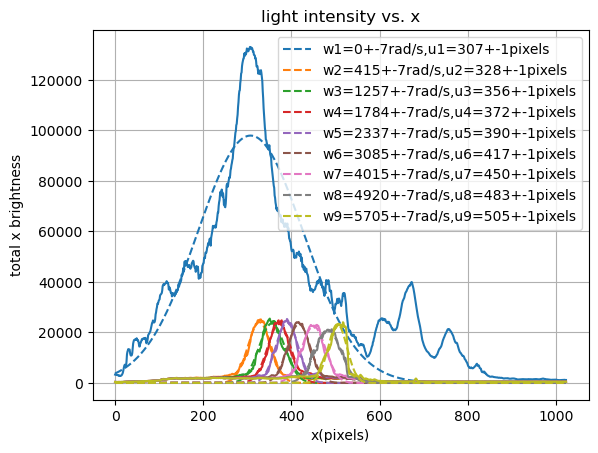

In [4]:
# Get x's
trials = [0 for i in range(9)]
for i in range(9):
    trials[i] = scan_img_intensity('./Imgs/image_' + str(i+1) + '.png')

# Plot intensities of images and gaussian fits
x = np.linspace(0, len(trials[0])-1, len(trials[0]))
means = [0 for i in range(9)]
dxs = [0 for i in range(8)]
dxs_adjusted = [0 for i in range(7)]
p0s = [[140000, 308, 1],[36000, 328, 1],[36000, 354, 1],\
       [36000, 371, 1],[36000, 390, 1],[35500, 416, 1],\
       [34000, 449, 1],[32000, 483, 1],[34500, 510, 1]]
for i in range(0, 9):
    trials[i] = scan_img_intensity('./Imgs/image_' + str(i+1) + '.png')
    plt.plot(x, trials[i],color=colors[i])

    # Plot guassian fit
    popt, pcov = curve_fit(gaussian, x, trials[i], p0=p0s[i])
    A, u, o = popt
    means[i] = u
    plt.plot(x, gaussian(x, A, u, o), label='w'+str(i+1)+'='+f'{freqs_rad[i]:.0f}'+"+-7rad/s,u"+str(i+1)+"="+f"{u:.0f}+-1pixels",color=colors[i],linestyle='dashed')

    # Get dx
    if i > 0:
        dxs[i-1] = pix_to_m(means[i] - means[0])
        if i > 1:
            dxs_adjusted[i-2] = pix_to_m(means[i] - (means[0] + means[1]) * 0.5)
plt.legend()
plt.xlabel('x(pixels)')
plt.ylabel('total x brightness')
plt.title('light intensity vs. x')
plt.grid()
print(dxs_adjusted)
plt.show()



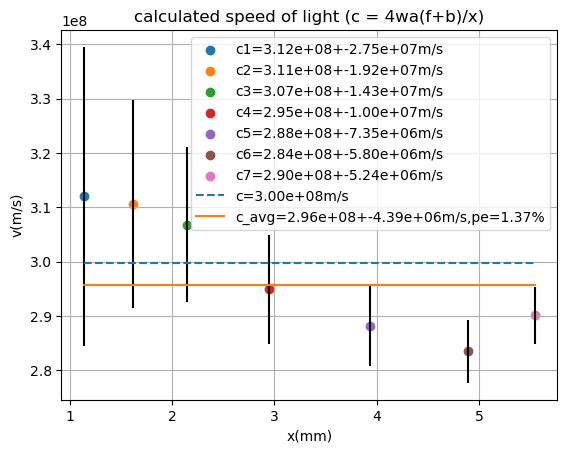

In [5]:
# Plot light speeds adjusted
lspeeds = [0 for i in range(7)]
for i in range(len(lspeeds)):
    lspeeds[i] = lightspeed(dxs_adjusted[i], freqs_rad[i+2])
lspeed = np.average(lspeeds[1:])
#ae = abs(c - lspeed)
pe = percent_error(c,lspeed)
std = np.std(lspeeds, ddof=1)
for i in range(len(lspeeds)):
    err = calculate_sigma_c(freqs_rad[i+2], dxs_adjusted[i])
    plt.errorbar(dxs_adjusted[i]*1000, lspeeds[i], yerr=err, color='k')
    plt.scatter(dxs_adjusted[i]*1000, lspeeds[i],label='c'+str(i+1)+f'={lspeeds[i]:.2e}+-{err:.2e}m/s')
# plt.plot([dxs_adjusted[0], dxs_adjusted[len(dxs_adjusted)-1]],[c,c],linestyle='dotted',label='c='+f"{c:.2f}")
# plt.plot([dxs_adjusted[0], dxs_adjusted[len(dxs_adjusted)-1]],[lspeed,lspeed],label='c_avg='+f"{lspeed:.2f}"+\
#          f',pe={percent_error(c,lspeed)}%')
plt.plot([dxs_adjusted[0]*1000, dxs_adjusted[len(dxs_adjusted)-1]*1000],[c,c],linestyle='dashed',label='c='+f"{c:.2e}m/s")
plt.plot([dxs_adjusted[0]*1000, dxs_adjusted[len(dxs_adjusted)-1]*1000],[lspeed,lspeed],label='c_avg='+f"{lspeed:.2e}+-{std / np.sqrt(len(lspeeds)):.2e}m/s"+\
         f',pe={pe:.2f}%')
plt.legend()
plt.xlabel('x(mm)')
plt.ylabel('v(m/s)')
plt.title('calculated speed of light (c = 4wa(f+b)/x)')
plt.grid()
plt.show()

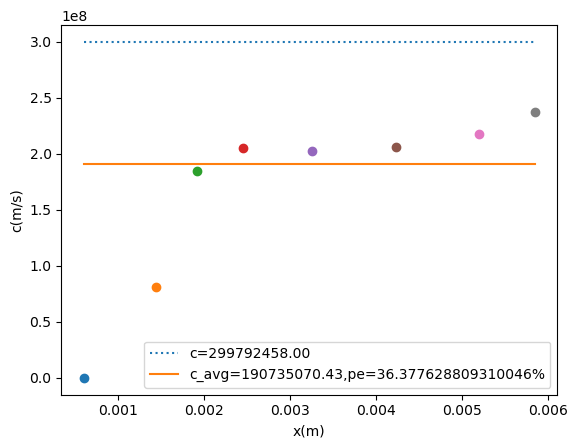

In [6]:

# Plot light speeds
lspeeds = [0 for i in range(8)]
for i in range(len(lspeeds)):
    lspeeds[i] = lightspeed(dxs[i], freqs_rad[i])
    plt.scatter(dxs[i], lspeeds[i])
lspeed = np.average(lspeeds[1:])
plt.plot([dxs[0], dxs[len(dxs)-1]],[c,c],linestyle='dotted',label='c='+f"{c:.2f}")
plt.plot([dxs[0], dxs[len(dxs)-1]],[lspeed,lspeed],label='c_avg='+f"{lspeed:.2f}"+\
         f',pe={percent_error(c,lspeed)}%')
plt.legend()
plt.xlabel('x(m)')
plt.ylabel('c(m/s)')
plt.show()